# Dice and IOU for rotated shapes

## Context
In Machine learning, the Dice and IOU (Intersection over Union) metrics are often used to calculate the accuracy of predictions.

In object detection, it is common to represent the predicted box vs the labeled box. But they are typically not rotated.

But when shapes are rotated like they are in the context of my app **Mix on Pix**, then it can be more complicated to
calculated the area of a shape or the area of the intersection of shapes.


Here we use the python shapely package to calculate the area of shapes and their intersections.

In [1]:
from platform import python_version

print(python_version())

3.8.3


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from six.moves import cPickle as pickle
from shapely.geometry import Polygon

import os

In [3]:
IMAGE_SIZE = 70 # images are 70px x 70 px

In [4]:
# Plot utility function
def plot_sample(X, y, pred, axs):
   
    axs.imshow(X.reshape(IMAGE_SIZE,   IMAGE_SIZE),cmap="gray")
    axs.scatter(IMAGE_SIZE*y[0::2],    IMAGE_SIZE*y[1::2],c='orange')
    axs.scatter(IMAGE_SIZE*pred[0::2], IMAGE_SIZE*pred[1::2],c='green')

In [5]:
# Calculate Accuracy
#
# IoU = |A∩B| / |A∪B| = |I| / |U|
def calculate_IOU(label, pred, nb_vertices=4):
    
    y_polygon   = Polygon(label.reshape(nb_vertices, 2))
    pred_polygon= Polygon(pred.reshape(nb_vertices, 2))

    I = y_polygon.intersection(pred_polygon).area
#    U = y_polygon.union(pred_polygon).area  # works, but below is better.
    U = y_polygon.area + pred_polygon.area - I
    IOU = I / U
    return IOU  

#
# Dice = 2 * |A∩B| / (|A| + |B|)
def calculate_Dice(label, pred, nb_vertices=4):
    
    y_polygon   = Polygon(label.reshape(nb_vertices, 2))
    pred_polygon= Polygon(pred.reshape(nb_vertices, 2))

    I = y_polygon.intersection(pred_polygon).area
    dice = 2 * I / (y_polygon.area + pred_polygon.area) 
    return dice

In [6]:
# data extracted from Mix on Pix training
with open("data/vertices.pickle", 'rb') as f:
    data_pickle = pickle.load(f)

In [7]:
real_images   = data_pickle['real_images']
real_vertices = data_pickle['real_vertices']
pred_vertices = data_pickle['pred_vertices']

In [8]:
# These coordinates:
# - Have the form: [x1,y1, x2,y2, x3,y3, x4,y4] where (0,0) is xxxx and (1,1) is
# - Are always ordered clockwize (this is important correctly compute the shape area).
print("real_vertices:", real_vertices)
print("pred_vertices:", pred_vertices)


real_vertices: [[0.28 0.87 0.27 0.13 0.77 0.12 0.78 0.88]
 [0.2  0.68 0.2  0.3  0.87 0.31 0.87 0.67]
 [0.2  0.56 0.2  0.42 0.87 0.43 0.88 0.55]]
pred_vertices: [[0.3072216  0.8773979  0.23711139 0.15532374 0.69328743 0.11481757
  0.75088876 0.8569454 ]
 [0.22403969 0.66231763 0.19804525 0.31432182 0.79703134 0.32084048
  0.8382528  0.6830623 ]
 [0.17497663 0.5377159  0.23399848 0.4222318  0.8701374  0.4788841
  0.82571185 0.5796747 ]]


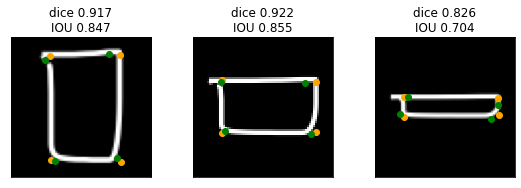

In [9]:
# Show Dice and IOU for a few images
#
# - The white lines are the user drawing
# - The orange dots represent the labeled position of the vertices
# - The green dots represent the predicted position of the vertices
#
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.13,wspace=0.3,
                    left=0,right=1,bottom=0, top=1)
nb_pictures = len(data_pickle)

for i in range(nb_pictures):
    ax = fig.add_subplot(nb_pictures//3 , 3, i+1, xticks=[], yticks=[])        
    plot_sample(real_images[i], real_vertices[i], pred_vertices[i], ax)
    
    dice = calculate_Dice(real_vertices[i], pred_vertices[i], nb_vertices=4)
    IOU  = calculate_IOU(real_vertices[i], pred_vertices[i], nb_vertices=4)
    
    ax.set_title("dice {:5.3f}\nIOU {:5.3f}".format(dice, IOU))
plt.show()